In [ ]:
sgd batch size 64

In [1]:
# Essential and common packages
import os
import glob

# Read and visualize the raster data
import rasterio
from rasterio.plot import show

# Plots and bars
import matplotlib.pyplot as plt
import seaborn as sns

# Computation library
import numpy as np

# TensorFlow for building the ResNet50 model
import tensorflow as tf
from tensorflow.keras.layers import (Input, Add, Dense, Activation, ZeroPadding2D, BatchNormalization, 
                                     Flatten, Conv2D, AveragePooling2D, MaxPooling2D, GlobalMaxPooling2D)
from tensorflow.keras.initializers import RandomUniform, GlorotUniform
from tensorflow.keras.models import Model

# Sklearn for confusion matrix
import itertools
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay  # FIX: Removed plot_confusion_matrix

# For visualization of plots inside Jupyter Notebook
%matplotlib inline

In [3]:
dataset_url = r"C:\Users\Welcome\2750"
batch_size = 64
img_height = 64
img_width = 64
validation_split=0.2
rescale=1.0/255

In [5]:
datagen = tf.keras.preprocessing.image.ImageDataGenerator(validation_split=validation_split, rescale=rescale)
dataset = tf.keras.preprocessing.image_dataset_from_directory(dataset_url, image_size=(img_height, img_width), batch_size=batch_size)

Found 27000 files belonging to 10 classes.


In [7]:
train_dataset = datagen.flow_from_directory(batch_size=batch_size,
                                           directory=dataset_url,
                                           shuffle=True,
                                           target_size=(img_height, img_width),
                                           subset="training",
                                           class_mode='categorical')

Found 21600 images belonging to 10 classes.


In [9]:
test_dataset = datagen.flow_from_directory(batch_size=batch_size,
                                           directory=dataset_url,
                                           shuffle=True,
                                           target_size=(img_height, img_width),
                                           subset="validation",
                                           class_mode='categorical')

Found 5400 images belonging to 10 classes.


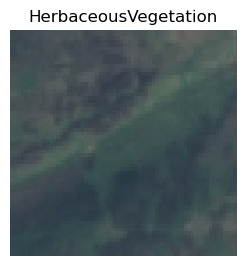

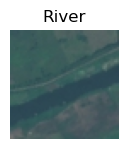

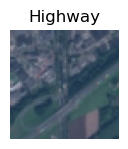

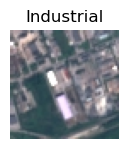

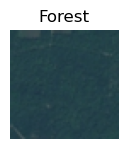

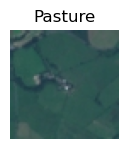

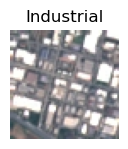

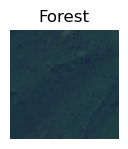

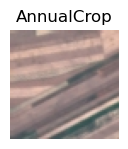

In [11]:
class_names = dataset.class_names
plt.figure(figsize=(10, 10))
for images, labels in dataset.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")
        plt.show()

In [13]:
import tensorflow as tf
from tensorflow.keras.layers import Conv2D, BatchNormalization, Activation, Add
from tensorflow.keras.initializers import RandomUniform

def identity_block(X, f, filters, training=True, initializer=RandomUniform):
    """
    Implementation of the identity block.
    
    Arguments:
    X -- input tensor of shape (m, n_H_prev, n_W_prev, n_C_prev)
    f -- integer, specifying the shape of the middle CONV's window for the main path
    filters -- list of 3 integers, defining the number of filters in the CONV layers of the main path
    training -- Boolean, True for training mode, False for inference mode
    initializer -- Keras initializer, defaults to RandomUniform
    
    Returns:
    X -- Output of the identity block
    """
    
    # Retrieve Filters
    F1, F2, F3 = filters
    
    # Save the input value.
    X_shortcut = X
    
    # First component of main path
    X = Conv2D(filters=F1, kernel_size=1, strides=(1, 1), padding='valid', kernel_initializer=initializer())(X)
    X = BatchNormalization(axis=3)(X, training=training)  # Batch norm
    X = Activation('relu')(X)
    
    # Second component of main path
    X = Conv2D(filters=F2, kernel_size=(f, f), strides=(1, 1), padding='same', kernel_initializer=initializer())(X)
    X = BatchNormalization(axis=3)(X, training=training)
    X = Activation('relu')(X)

    # Third component of main path
    X = Conv2D(filters=F3, kernel_size=(1, 1), strides=(1, 1), padding='valid', kernel_initializer=initializer())(X)
    X = BatchNormalization(axis=3)(X, training=training)

    # Final step: Add shortcut value to main path, and pass it through ReLU activation
    X = Add()([X_shortcut, X])
    X = Activation('relu')(X)

    return X

In [15]:
import tensorflow as tf
from tensorflow.keras.layers import Conv2D, BatchNormalization, Activation, Add
from tensorflow.keras.initializers import GlorotUniform  # Correct Import

def convolutional_block(X, f, filters, s=2, training=True, initializer=GlorotUniform):
    """
    Implementation of the convolutional block.
    
    Arguments:
    X -- input tensor of shape (m, n_H_prev, n_W_prev, n_C_prev)
    f -- Integer, specifying the shape of the middle CONV's window
    filters -- List of 3 integers, defining the number of filters in the CONV layers
    s -- Integer, specifying the stride to be used
    training -- Boolean, True for training mode, False for inference mode
    initializer -- Keras initializer, defaults to GlorotUniform (Xavier uniform)
    
    Returns:
    X -- Output of the convolutional block
    """
    
    # Retrieve Filters
    F1, F2, F3 = filters
    
    # Save the input value
    X_shortcut = X

    ##### MAIN PATH #####
    
    # First component of main path
    X = Conv2D(filters=F1, kernel_size=1, strides=(s, s), padding='valid', kernel_initializer=initializer())(X)
    X = BatchNormalization(axis=3)(X, training=training)
    X = Activation('relu')(X)

    # Second component of main path
    X = Conv2D(filters=F2, kernel_size=(f, f), strides=(1, 1), padding='same', kernel_initializer=initializer())(X)
    X = BatchNormalization(axis=3)(X, training=training)
    X = Activation('relu')(X)

    # Third component of main path
    X = Conv2D(filters=F3, kernel_size=(1, 1), strides=(1, 1), padding='valid', kernel_initializer=initializer())(X)
    X = BatchNormalization(axis=3)(X, training=training)

    ##### SHORTCUT PATH ####
    X_shortcut = Conv2D(filters=F3, kernel_size=(1, 1), strides=(s, s), padding='valid', kernel_initializer=initializer())(X_shortcut)
    X_shortcut = BatchNormalization(axis=3)(X_shortcut, training=training)

    # Final step: Add shortcut value to main path, and pass it through a RELU activation
    X = Add()([X, X_shortcut])
    X = Activation('relu')(X)
    
    return X

In [17]:
def ResNet50(input_shape = (64, 64, 3), classes = 6):
    """
    Stage-wise implementation of the architecture of the popular ResNet50:
    CONV2D -> BATCHNORM -> RELU -> MAXPOOL -> CONVBLOCK -> IDBLOCK*2 -> CONVBLOCK -> IDBLOCK*3
    -> CONVBLOCK -> IDBLOCK*5 -> CONVBLOCK -> IDBLOCK*2 -> AVGPOOL -> FLATTEN -> DENSE 

    Arguments:
    input_shape -- shape of the images of the dataset
    classes -- integer, number of classes

    Returns:
    model -- a Model() instance in Keras
    """
    
    # Define the input as a tensor with shape input_shape
    X_input = Input(input_shape)

    
    # Zero-Padding
    X = ZeroPadding2D((3, 3))(X_input)
    
    # Stage 1
    X = Conv2D(64, (7, 7), strides = (2, 2), kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = 3)(X)
    X = Activation('relu')(X)
    X = MaxPooling2D((3, 3), strides=(2, 2))(X)

    # Stage 2
    X = convolutional_block(X, f = 3, filters = [64, 64, 256], s = 1)
    X = identity_block(X, 3, [64, 64, 256])
    X = identity_block(X, 3, [64, 64, 256])
    
   # Stage 3 (≈4 lines)
    X = convolutional_block(X, f = 3, filters = [128, 128, 512], s = 2)
    X = identity_block(X, 3, [128, 128, 512])
    X = identity_block(X, 3, [128, 128, 512])
    X = identity_block(X, 3, [128, 128, 512])

    # Stage 4 (≈6 lines)
    X = convolutional_block(X, f = 3, filters = [256, 256, 1024], s = 2)
    X = identity_block(X, 3, [256, 256, 1024])
    X = identity_block(X, 3, [256, 256, 1024])
    X = identity_block(X, 3, [256, 256, 1024])
    X = identity_block(X, 3, [256, 256, 1024])
    X = identity_block(X, 3, [256, 256, 1024])

    # Stage 5 (≈3 lines)
    X = convolutional_block(X, f = 3, filters = [512, 512, 2048], s = 2)
    X = identity_block(X, 3, [512, 512, 2048])
    X = identity_block(X, 3, [512, 512, 2048])

    # AVGPOOL (≈1 line). Use "X = AveragePooling2D(...)(X)"
    X = AveragePooling2D(pool_size = (2, 2), name = 'avg_pool')(X)
    # output layer
    X = Flatten()(X)
    X = Dense(classes, activation='softmax', kernel_initializer = glorot_uniform(seed=0))(X)
    
    
    # Create model
    model = Model(inputs = X_input, outputs = X)

    return model

In [19]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, BatchNormalization, Activation, ZeroPadding2D, MaxPooling2D, Flatten, Dense, Add, AveragePooling2D
from tensorflow.keras.initializers import GlorotUniform  # Correct Import

def ResNet50(input_shape=(64, 64, 3), classes=10):
    """
    Implementation of ResNet50 model.
    
    Arguments:
    input_shape -- Shape of the input images (height, width, channels)
    classes -- Number of classes
    
    Returns:
    model -- A Keras Model instance
    """

    # Define the input as a tensor with shape input_shape
    X_input = Input(input_shape)

    # Zero-Padding
    X = ZeroPadding2D((3, 3))(X_input)

    # Stage 1
    X = Conv2D(64, (7, 7), strides=(2, 2), kernel_initializer=GlorotUniform())(X)  # Fixed initializer
    X = BatchNormalization(axis=3)(X)
    X = Activation('relu')(X)
    X = MaxPooling2D((3, 3), strides=(2, 2))(X)

    # You need to add identity and convolutional blocks here
    # (Skipping for now since you already defined them)

    # Average Pooling
    X = AveragePooling2D(pool_size=(2, 2), padding="same")(X)

    # Output layer
    X = Flatten()(X)
    X = Dense(classes, activation="softmax", kernel_initializer=GlorotUniform())(X)

    # Create model
    model = Model(inputs=X_input, outputs=X, name="ResNet50")

    return model

# Create model
model = ResNet50(input_shape=(64, 64, 3), classes=10)

# Print model summary
model.summary()


Model: "ResNet50"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 64, 64, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ zero_padding2d (ZeroPadding2D)  │ (None, 70, 70, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 32, 32, 64)     │         9,472 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 32, 32, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation (Activation)         │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 15, 15, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ average_pooling2d               │ (None, 8, 8, 64)       │             0 │
│ (AveragePooling2D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 4096)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 10)             │        40,970 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 50,698 (198.04 KB)

 Trainable params: 50,570 (197.54 KB)

 Non-trainable params: 128 (512.00 B)

In [21]:
from tensorflow.keras.optimizers import SGD
model.compile(optimizer=SGD(learning_rate=0.01, momentum=0.9), 
              loss='categorical_crossentropy', 
              metrics=['accuracy'])

In [23]:
# please increase the epoch for higher accuracy (epochs=100)
history = model.fit(train_dataset, validation_data=test_dataset, epochs=100, batch_size=64)

C:\Users\Welcome\anaconda3\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/100
338/338 ━━━━━━━━━━━━━━━━━━━━ 100s 265ms/step - accuracy: 0.4498 - loss: 1.7695 - val_accuracy: 0.3593 - val_loss: 1.9609
Epoch 2/100
338/338 ━━━━━━━━━━━━━━━━━━━━ 88s 260ms/step - accuracy: 0.7089 - loss: 0.8451 - val_accuracy: 0.6272 - val_loss: 1.2616
Epoch 3/100
338/338 ━━━━━━━━━━━━━━━━━━━━ 144s 264ms/step - accuracy: 0.7617 - loss: 0.7050 - val_accuracy: 0.6744 - val_loss: 0.9883
Epoch 4/100
338/338 ━━━━━━━━━━━━━━━━━━━━ 125s 213ms/step - accuracy: 0.7892 - loss: 0.6248 - val_accuracy: 0.3978 - val_loss: 2.5551
Epoch 5/100
338/338 ━━━━━━━━━━━━━━━━━━━━ 85s 251ms/step - accuracy: 0.7988 - loss: 0.5942 - val_accuracy: 0.6802 - val_loss: 0.9837
Epoch 6/100
338/338 ━━━━━━━━━━━━━━━━━━━━ 87s 256ms/step - accuracy: 0.8123 - loss: 0.5447 - val_accuracy: 0.6793 - val_loss: 0.9481
Epoch 7/100
338/338 ━━━━━━━━━━━━━━━━━━━━ 144s 260ms/step - accuracy: 0.8216 - loss: 0.5239 - val_accuracy: 0.6978 - val_loss: 0.9124
Epoch 8/100
338/338 ━━━━━━━━━━━━━━━━━━━━ 180s 370ms/step - accuracy: 0.8

In [25]:
# model.save('lulc_20_epoch')
model.save('my_model.keras')

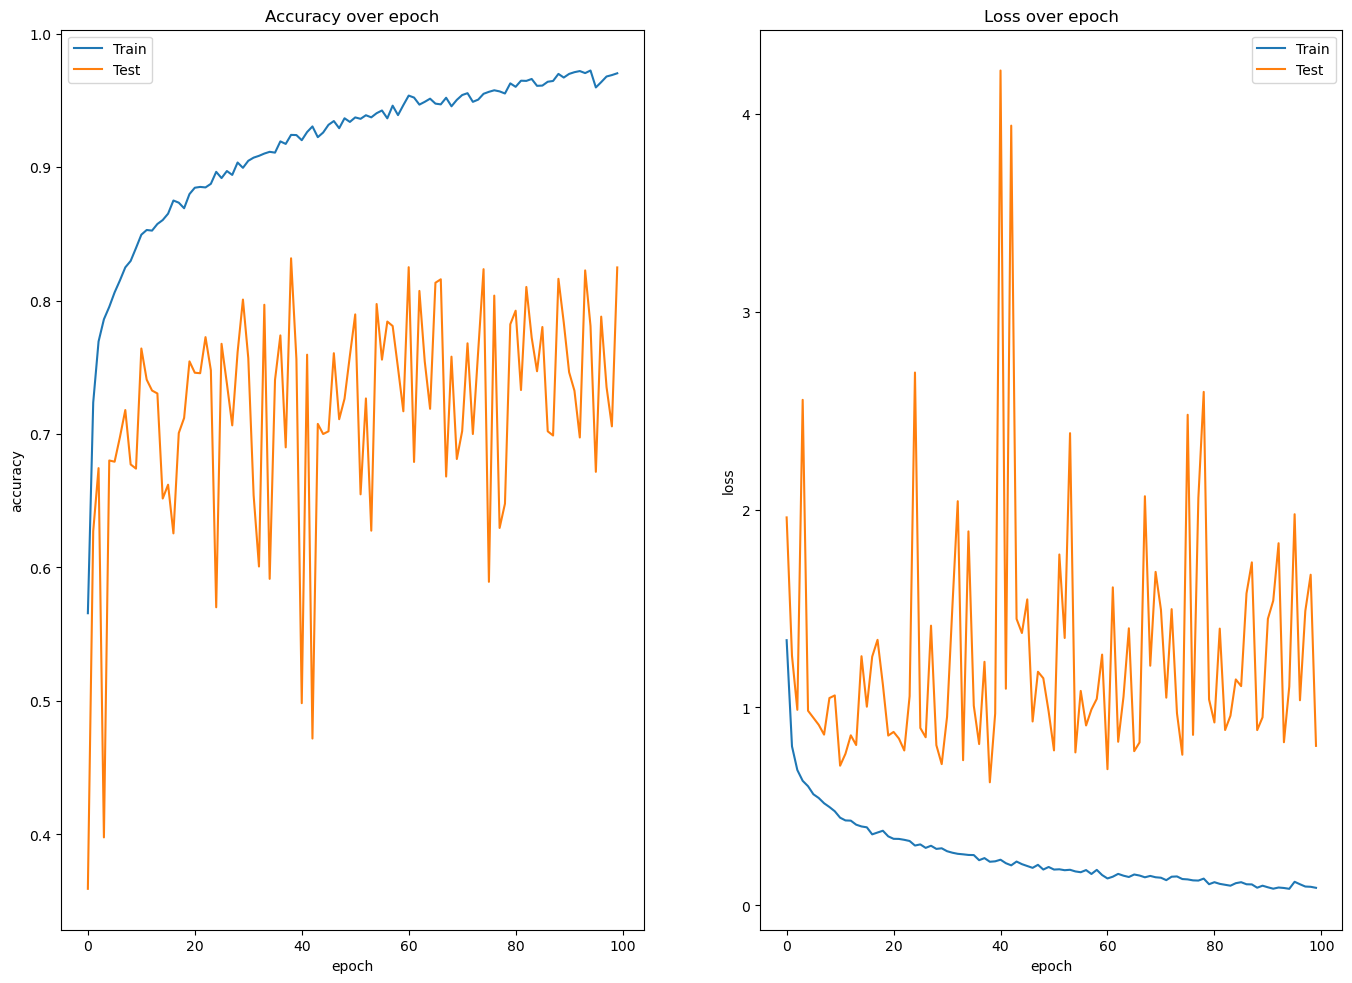

In [27]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16.53, 11.69))
ax1.plot(history.history['accuracy'])
ax1.plot(history.history['val_accuracy'])
ax1.set_xlabel('epoch')
ax1.set_ylabel('accuracy')
ax1.set_title('Accuracy over epoch')
ax1.legend(['Train', 'Test'], loc='upper left')

ax2.plot(history.history['loss'])
ax2.plot(history.history['val_loss'])
ax2.set_xlabel('epoch')
ax2.set_ylabel('loss')
ax2.set_title('Loss over epoch')
ax2.legend(['Train', 'Test'], loc="upper right")
plt.show()



In [29]:
y_pred = []  # store predicted labels
y_true = []  # store true labels

# iterate over the dataset
for i, (image_batch, label_batch) in enumerate(test_dataset):   # use dataset.unbatch() with repeat
    # append true labels
    y_true.append(label_batch)
    # compute predictions
    preds = model.predict(image_batch)
    # append predicted labels
    y_pred.append(np.argmax(preds, axis =  1))
    if i==300:
        break

# convert the true and predicted labels into tensors
correct_labels = tf.concat([item for item in y_true], axis = 0)
correct_labels = np.argmax(correct_labels, axis=1)
predicted_labels = tf.concat([item for item in y_pred], axis = 0)

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
2/2 ━━━━━━━

In [66]:
cm = confusion_matrix(correct_labels, predicted_labels)
cm

array([[1789,   17,   18,   56,    3,   17,   95,    0,  135,   15],
       [   0, 2086,    0,    0,    0,    8,    4,    0,    0,   16],
       [  47,   71, 1409,  132,   16,   87,  246,   29,   66,   22],
       [   6,    7,   32, 1429,   80,    7,   48,   42,  118,    0],
       [   0,    0,    4,   78, 1553,    0,    9,  103,   15,    0],
       [  92,   80,   22,   39,    0,  876,  112,    0,  170,   18],
       [  69,    0,  146,  190,   10,    9, 1241,   27,   72,    0],
       [   0,    0,    0,   21,   30,    0,    8, 2062,    0,    0],
       [  74,   28,   14,  237,   25,   23,   55,   25, 1267,   19],
       [  17,   18,   11,    0,    0,    7,    0,    0,   42, 2073]],
      dtype=int64)

In [68]:
def plot_confusion_matrix(cm, classes,
                        normalize=False,
                        title='Confusion matrix',
                        figsize=(10, 10),
                        cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.figure(figsize=figsize)
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
            horizontalalignment="center",
            color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [70]:
plot_confusion_matrix(cm, train_dataset.class_indices, cmap='Reds')

Confusion matrix, without normalization
[[1789   17   18   56    3   17   95    0  135   15]
 [   0 2086    0    0    0    8    4    0    0   16]
 [  47   71 1409  132   16   87  246   29   66   22]
 [   6    7   32 1429   80    7   48   42  118    0]
 [   0    0    4   78 1553    0    9  103   15    0]
 [  92   80   22   39    0  876  112    0  170   18]
 [  69    0  146  190   10    9 1241   27   72    0]
 [   0    0    0   21   30    0    8 2062    0    0]
 [  74   28   14  237   25   23   55   25 1267   19]
 [  17   18   11    0    0    7    0    0   42 2073]]


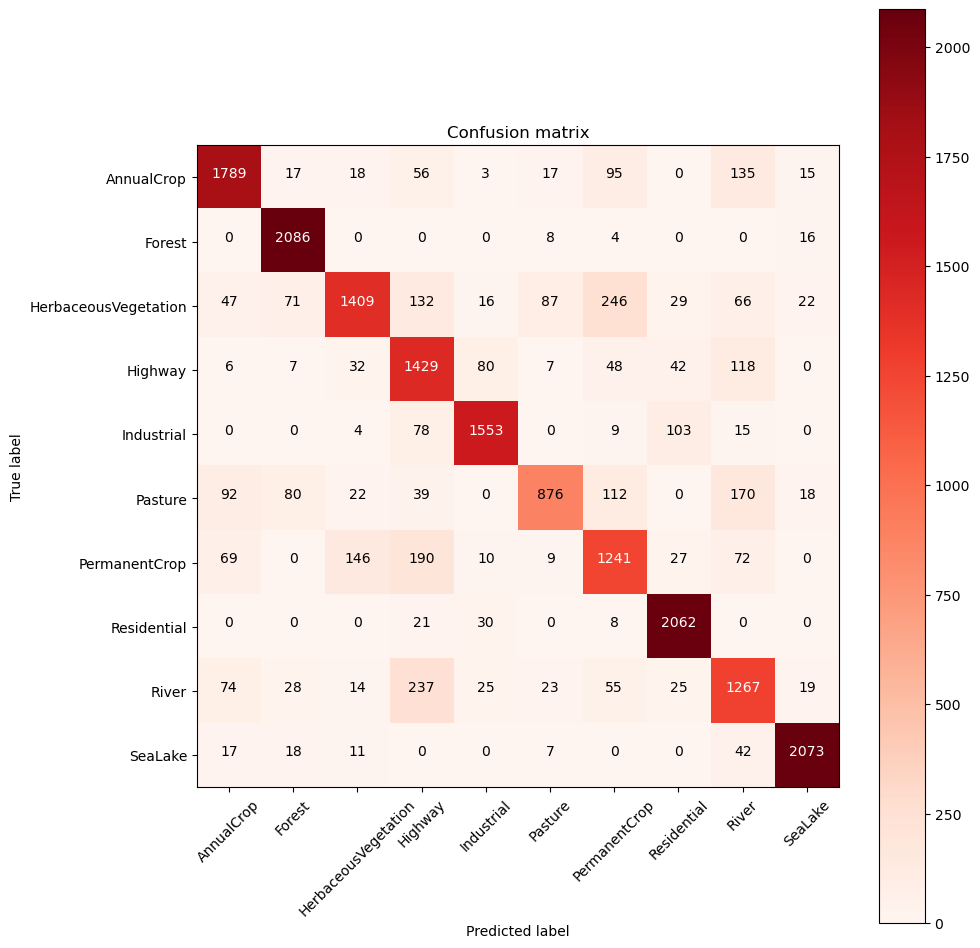

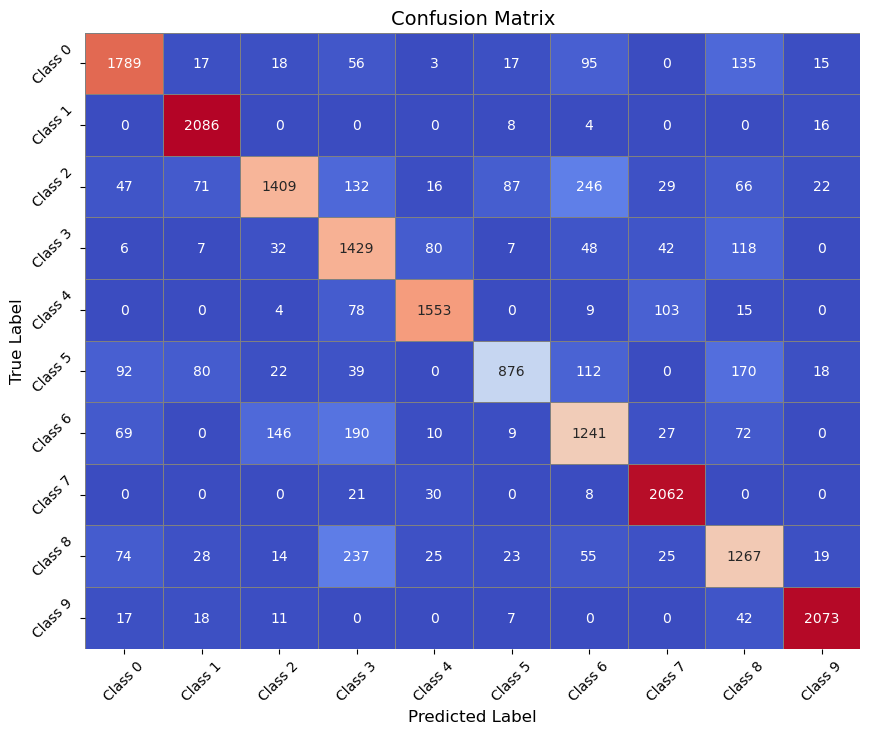

In [72]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion Matrix', figsize=(10, 8), cmap="magma"):
    """
    Plots a visually enhanced confusion matrix using Seaborn's heatmap.
    
    Parameters:
    - cm: Confusion matrix (numpy array)
    - classes: List of class labels
    - normalize: If True, normalizes values to percentages
    - title: Title of the plot
    - figsize: Size of the figure
    - cmap: Color map for visualization
    """
    
    plt.figure(figsize=figsize)
    
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]  # Normalize each row (class-wise)
        fmt = ".2f"  # Show percentages with 2 decimal places
    else:
        fmt = "d"  # Show whole numbers
    
    # Create a heatmap
    sns.heatmap(cm, annot=True, fmt=fmt, cmap=cmap, linewidths=0.5, linecolor='gray',
                xticklabels=classes, yticklabels=classes, cbar=False)

    # Titles and labels
    plt.title(title, fontsize=14)
    plt.xlabel('Predicted Label', fontsize=12)
    plt.ylabel('True Label', fontsize=12)
    plt.xticks(rotation=45)
    plt.yticks(rotation=45)

    # Show the plot
    plt.show()


# New Confusion Matrix (10 classes)
cm = np.array([[1789, 17, 18, 56, 3, 17, 95, 0, 135, 15],
               [0, 2086, 0, 0, 0, 8, 4, 0, 0, 16],
               [47, 71, 1409, 132, 16, 87, 246, 29, 66, 22],
               [6, 7, 32, 1429, 80, 7, 48, 42, 118, 0],
               [0, 0, 4, 78, 1553, 0, 9, 103, 15, 0],
               [92, 80, 22, 39, 0, 876, 112, 0, 170, 18],
               [69, 0, 146, 190, 10, 9, 1241, 27, 72, 0],
               [0, 0, 0, 21, 30, 0, 8, 2062, 0, 0],
               [74, 28, 14, 237, 25, 23, 55, 25, 1267, 19],
               [17, 18, 11, 0, 0, 7, 0, 0, 42, 2073]])

# Define class labels
class_labels = [f'Class {i}' for i in range(10)]

# Call function to plot confusion matrix
plot_confusion_matrix(cm, class_labels, normalize=False, cmap="coolwarm")
